In [1]:
!pip install ollama chromadb

In [2]:
import ollama
import chromadb

documents = [
  "Llamas are members of the camelid family meaning they're pretty closely related to vicuñas and camels",
  "Llamas were first domesticated and used as pack animals 4,000 to 5,000 years ago in the Peruvian highlands",
  "Llamas can grow as much as 6 feet tall though the average llama between 5 feet 6 inches and 5 feet 9 inches tall",
  "Llamas weigh between 280 and 450 pounds and can carry 25 to 30 percent of their body weight",
  "Llamas are vegetarians and have very efficient digestive systems",
  "Llamas live to be about 20 years old, though some only live for 15 years and others live to be 30 years old",
]

client = chromadb.Client()
collection = client.create_collection(name="docs")

# store each document in a vector embedding database
for i, d in enumerate(documents):
  response = ollama.embeddings(model="mxbai-embed-large", prompt=d)
  embedding = response["embedding"]
  collection.add(
    ids=[str(i)],
    embeddings=[embedding],
    documents=[d]
  )

In [3]:
# an example prompt
prompt = "What animals are llamas related to?"

# generate an embedding for the prompt and retrieve the most relevant doc
response = ollama.embeddings(
  prompt=prompt,
  model="mxbai-embed-large"
)
results = collection.query(
  query_embeddings=[response["embedding"]],
  n_results=1
)
data = results['documents'][0][0]
data

"Llamas are members of the camelid family meaning they're pretty closely related to vicuñas and camels"

In [4]:
# generate a response combining the prompt and data we retrieved in step 2
output = ollama.generate(
  model="llama3.1:latest",
  prompt=f"Using this data: {data}. Respond to this prompt: {prompt}"
)

print(output['response'])

Llamas are closely related to vicuñas, camels, and other members of the camelid family.


In [11]:
# import ollama

# # Open the image file as a file-like object
# with open('dbce3856-7dca-4040-a96d-ce811cefc43e.jpg', 'rb') as image_file:
#     # Interact with the LLAVA model, passing the image as a file-like object
#     res = ollama.chat(
#         model="llava:latest",
#         messages=[
#             {
#                 'role': 'user',
#                 'content': 'Describe this image:',
#                 'images': [image_file]
#             }
#         ]
#     )

# # Print the model's response
# print(res['message']['content'])


In [8]:
pwd

'c:\\Users\\A507658\\Downloads\\docker_wishper\\RAG'

In [12]:
import ollama

# Using the ollama.chat function to interact with the LLAVA model
res = ollama.chat(
    model="llava:latest",
    messages=[
        {
            'role': 'user',
            'content': 'What is AI?',
            
        }
    ]
)

# Printing the response from the model
print(res['message']['content'])


 AI stands for Artificial Intelligence, which refers to the development of computer systems that can perform tasks typically requiring human intelligence, such as understanding natural language, recognizing objects in images, and playing games. 


In [5]:
import ollama
import os
import chromadb

data_dir = 'NHSData/'


client = chromadb.PersistentClient(path="db/")

collection = client.get_or_create_collection("readme_collection")

for filename in os.listdir(data_dir):
    if filename.endswith('.md'):
        with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
            content = file.read()
            embeddings = ollama.embeddings(
                            model='mxbai-embed-large',
                            prompt=content,
                            )
            # Add document and its embedding to the collection
            collection.add(
                ids=[filename], 
                documents=[content], 
                embeddings=[embeddings['embedding']]
            )

print("Embeddings created and stored in ChromaDB.")


Embeddings created and stored in ChromaDB.


In [1]:
import ollama
import chromadb

client = chromadb.PersistentClient(path="db/")
collection = client.get_collection("readme_collection")

def retrieve_document(query,n_results):
    query_embedding = ollama.embeddings(
                            model='mxbai-embed-large',
                            prompt=query,
                            )
    results = collection.query(
        query_embeddings=[query_embedding['embedding']],
        n_results=n_results
    )
    if results['documents']:
        return results['documents'][0], results['ids'][0]
    else:
        return "No relevant document found", None




In [69]:
def rag_system(query,n_results):
    document_content, document_id = retrieve_document(query,n_results)
    finalData = []
    if document_id is None:
        return "No relevant document found"
    for res,doc_name in zip(document_content,document_id):
        try:
            response = ollama.chat(
                model="llama3.1:latest",
                messages=[
                    {'role': 'user', 'content': f"You are expect in analysing the query: {query} and the relevant context for the provided query as follows {res}. Based on it try to generate concise response which should be very short and accurate response."},
                ]
            )
            finalData.append({"result":response['message']['content'],"document_id":doc_name})
        except Exception as e:
            return f"An error occurred: {str(e)}"
    return finalData


query = "What is yellow fever?"
response = rag_system(query,2)
from rich import print
print(response)

[
    {
        'result': 'Yellow fever is a serious infection spread by mosquitoes, found in certain areas of Africa and 
South America. Symptoms include high temperature, headache, feeling unwell, and jaundice (yellowing of the skin and
eyes). Treatment involves rest, hydration, and pain management; severe cases require hospitalization.',
        'document_id': 'yellow-fever.md'
    },
    {
        'result': 'The provided content is not relevant to the query "What is yellow fever?" as it discusses bird 
flu, a different infectious disease. However, if we were to focus on providing context for analyzing queries about 
infectious diseases, here\'s a possible response:\n\nWhen analyzing queries about infectious diseases like bird flu
or yellow fever, it\'s essential to consider various factors such as the type of virus, its transmission routes, 
symptoms, and potential complications. This information can help provide accurate answers and ensure public health 
guidelines are followed.\n\nIn this case, since there is no relevant context for yellow fever in the provided 
content, a direct answer would be:\n\nYellow fever is not discussed in the provided content, which focuses on bird 
flu.',
        'document_id': 'bird-flu.md'
    }
]

In [2]:
def rag_system_groq(query,n_results):
    import os
    api = "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"
    from groq import Groq
    client = Groq(
    api_key=api,
)
    document_content, document_id = retrieve_document(query,n_results)
    finalData = []
    if document_id is None:
        return "No relevant document found"
    for res,doc_name in zip(document_content,document_id):
        try:
            chat_completion = client.chat.completions.create(
                                                        messages=[
                                                            {
                                                                "role": "user",
                                                                "content": f"You are an expert in analyzing queries and their relevant context. Given the query: {query} and the context: {res}, generate a concise and accurate response. If the provided context {res} does not offer meaningful information for the query {query}, create an appropriate, concise response instead."
                                                                # "You are expect in analysing the query: {query} and the relevant context for the provided query as follows {res}. Based on it try to generate concise response which should be very short and accurate response. if the context {res} does not provided meaningful information for the query {query}. Then try to generate appripiate response in consise version.",
                                                            }
                                                        ],
                                                        model="llama3-70b-8192")

            # response = ollama.chat(
            #     model="llama3.1:latest",
            #     messages=[
            #         {'role': 'user', 'content': f"You are expect in analysing the query: {query} and the relevant context for the provided query as follows {res}. Based on it try to generate concise response which should be very short and accurate response."},
            #     ]
            # )
            finalData.append({"result":chat_completion.choices[0].message.content,"document_id":doc_name})
        except Exception as e:
            return f"An error occurred: {str(e)}"
    return finalData


query = "What is yellow fever?"
response = rag_system_groq(query,2)
from rich import print
print(response)

[
    {
        'result': 'Yellow fever is a serious infection spread by mosquitoes, commonly found in certain areas of 
Africa and South and Central America. It can be prevented with a yellow fever vaccination, especially for travelers
to high-risk areas. If infected, symptoms may include high temperature, headache, and flu-like symptoms, which can 
lead to more severe and potentially life-threatening symptoms such as jaundice, dark urine, and bleeding.',
        'document_id': 'yellow-fever.md'
    },
    {
        'result': "I apologize, but the provided context is about bird flu and does not mention yellow fever. 
Yellow fever is a different disease, and I don't have enough information to provide an accurate response based on 
the given context.\n\nHowever, I can provide a brief general answer: Yellow fever is a viral disease transmitted by
mosquitoes, primarily affecting humans and monkeys. It's commonly found in tropical and subtropical regions of 
Africa and South America. Symptoms can range from mild to severe, including fever, chills, and vomiting. In severe 
cases, it can lead to hemorrhaging, organ failure, and even death. Vaccination is the most effective way to prevent
yellow fever.\n\nIf you have any more specific questions or would like more information on yellow fever, I'd be 
happy to help.",
        'document_id': 'bird-flu.md'
    }
]

In [71]:
query = "What is yellow fever?"
response = rag_system(query,5)
from rich import print
print(response)

[
    {
        'result': '**Yellow Fever:** A serious infection spread by mosquitoes, found in parts of Africa and 
South/Central America.\n\nKey points:\n\n*   **Transmission**: Through bites from infected mosquitoes.\n*   
**Vaccination**: Recommended for travelers to affected areas.\n*   **Symptoms**: High temperature, headache, 
feeling sick, aches and pains, loss of appetite, and jaundice (yellowing of skin and eyes).\n*   **Treatment**: No 
specific treatment; most people recover within 3-4 days.',
        'document_id': 'yellow-fever.md'
    },
    {
        'result': "Based on the provided context, I don't see any information about yellow fever. The context is 
about Bird flu (avian influenza). If you have a specific question about bird flu or its symptoms, I can help with 
that!",
        'document_id': 'bird-flu.md'
    },
    {
        'result': 'Based on the provided context, I realize that the query "What is yellow fever?" doesn\'t match 
the content. The correct answer would be:\n\nThe text doesn\'t mention Yellow Fever at all. It\'s about Hay 
Fever.',
        'document_id': 'hay-fever.md'
    },
    {
        'result': 'The provided text is about Dengue, not Yellow Fever.\n\nHowever, if we analyze the context of 
the query "What is yellow fever?" and consider that it\'s related to mosquito-borne diseases in tropical areas, a 
possible answer could be:\n\n"Yellow Fever is another disease spread by infected mosquitoes, similar to Dengue. 
It\'s also found in tropical regions, but with different symptoms."\n\nThis response acknowledges the connection 
between both diseases, which might have led to the confusion. However, it\'s essential to note that the query was 
not answered directly from the provided text but rather inferred based on context.',
        'document_id': 'dengue.md'
    },
    {
        'result': 'Based on the provided query "What is yellow fever?" I couldn\'t find any relevant information in
the context of the given text, which appears to be about a high temperature (fever) in children. However, I can 
provide you with some general information about yellow fever.\n\nYellow fever is a viral disease transmitted by 
mosquitoes that occurs in certain parts of Africa and South America. It\'s characterized by symptoms like fever, 
chills, headache, muscle pain, and nausea, which can progress to severe bleeding and organ failure if left 
untreated.\n\nIf you\'re looking for more specific information on yellow fever, I\'d be happy to help with a new 
query!',
        'document_id': 'fever-in-children.md'
    }
]

In [9]:
query = "I have cold and fever from last 5 days and not able to handle anywork what might be the reason"
response = rag_system(query,1)
from rich import print
print(response)
rag_system_groq

NameError: name 'rag_system' is not defined

In [34]:
query = "I have cold and fever from last 5 days and not able to handle anywork what might be the reason"
response = rag_system_groq(query,1)
from rich import print
print(response)


[
    {
        'result': "Based on your symptoms of cold and fever for the last 5 days, and difficulty handling work, it's
possible that you may be experiencing Sick Building Syndrome (SBS). This is because SBS symptoms, such as 
headaches, tiredness, and respiratory issues, worsen while you're in a particular building and improve after 
leaving it. Consider speaking to your manager or building manager to investigate the issue, and try to ease 
symptoms by improving ventilation, reducing stress, and taking regular breaks.",
        'document_id': 'sick-building-syndrome.md'
    }
]

In [4]:
def getresponse(query,n_results):
    try:
        response = rag_system_groq(query,n_results)
        from rich import print
        return response
    except Exception as e:
        print(f"An error occurred: {e}")
getresponse(query = "I have cold and fever from last 5 days and not able to handle anywork what might be the reason",n_results=2)

[{'result': "Based on your symptoms of having a cold and fever for the last 5 days, which are preventing you from handling any work, it's unlikely that Sick Building Syndrome (SBS) is the primary cause. SBS is typically characterized by symptoms that worsen when you're in a particular building and improve when you leave. Your symptoms seem to be more related to a common illness like a viral infection or flu.\n\nThe reason behind your symptoms could be a viral or bacterial infection, which is common during cold and flu seasons. It's essential to consult a healthcare professional to determine the underlying cause of your illness and receive appropriate treatment. In the meantime, make sure to get plenty of rest, stay hydrated, and take over-the-counter medications to manage your symptoms.\n\nIt's also a good idea to take precautions to prevent the spread of infection, such as washing your hands frequently, covering your mouth and nose when coughing or sneezing, and avoiding close contact

In [49]:
res = getresponse(query = "Does Autism affect human speech?",n_results=1)
for i in res:
    from IPython.display import Markdown
    display(Markdown(i['result']))
    print(i['document_id'])


Based on the provided context, the article does not directly address the question "Does Autism affect human speech?" The article focuses on Dysarthria, a condition that causes difficulty speaking due to weak speech muscles, and its causes, symptoms, and treatment.

To answer your question, Autism Spectrum Disorder (ASD) can indeed affect human speech. Individuals with ASD may experience difficulties with verbal and nonverbal communication, including delayed speech development, difficulty articulating words, and struggles with understanding and using language. However, this information is not provided in the given context.

If you would like to know more about how Autism affects human speech, I can provide you with more information or suggest resources on the topic.

dysarthria.md

In [5]:
res = getresponse(query = "What are the factors for fatty liver? And how to prevent it",n_results=1)
for i in res:
    from IPython.display import Markdown
    display(Markdown(i['result']))
    print(i['document_id'])


**Factors for Fatty Liver (NAFLD):**

* Being overweight or obese, especially with a lot of fat around the waist
* Having type 2 diabetes
* Having a condition that affects insulin use, such as polycystic ovary syndrome
* Having an underactive thyroid
* Having high blood pressure
* Having high cholesterol
* Having metabolic syndrome (a combination of diabetes, high blood pressure, and obesity)
* Being over 50 years old
* Smoking

**How to Prevent Fatty Liver (NAFLD):**

* Maintaining a healthy weight through a balanced diet and regular exercise
* Eating a healthy diet high in fruits, vegetables, protein, and carbohydrates, but low in fat, sugar, and salt
* Drinking water instead of sweet drinks
* Exercising regularly, aiming for at least 150 minutes of moderate-intensity activity per week
* Stopping smoking
* Limiting or avoiding alcohol consumption

By adopting these healthy lifestyle choices, you can reduce your risk of developing fatty liver disease and improve your overall health.

non-alcoholic-fatty-liver-disease.md

In [77]:
for i in response:
    print("Result: ",i["result"])
    print("DOcument ID :",i['document_id'])
    print("-"*50)

Result:  **Yellow Fever:** A serious infection spread by mosquitoes, found in parts of Africa and South/Central 
America.

Key points:

*   **Transmission**: Through bites from infected mosquitoes.
*   **Vaccination**: Recommended for travelers to affected areas.
*   **Symptoms**: High temperature, headache, feeling sick, aches and pains, loss of appetite, and jaundice 
(yellowing of skin and eyes).
*   **Treatment**: No specific treatment; most people recover within 3-4 days.

DOcument ID : yellow-fever.md

--------------------------------------------------

Result:  Based on the provided context, I don't see any information about yellow fever. The context is about Bird 
flu (avian influenza). If you have a specific question about bird flu or its symptoms, I can help with that!

DOcument ID : bird-flu.md

--------------------------------------------------

Result:  Based on the provided context, I realize that the query "What is yellow fever?" doesn't match the content.
The correct answer would be:

The text doesn't mention Yellow Fever at all. It's about Hay Fever.

DOcument ID : hay-fever.md

--------------------------------------------------

Result:  The provided text is about Dengue, not Yellow Fever.

However, if we analyze the context of the query "What is yellow fever?" and consider that it's related to 
mosquito-borne diseases in tropical areas, a possible answer could be:

"Yellow Fever is another disease spread by infected mosquitoes, similar to Dengue. It's also found in tropical 
regions, but with different symptoms."

This response acknowledges the connection between both diseases, which might have led to the confusion. However, 
it's essential to note that the query was not answered directly from the provided text but rather inferred based on
context.

DOcument ID : dengue.md

--------------------------------------------------

Result:  Based on the provided query "What is yellow fever?" I couldn't find any relevant information in the 
context of the given text, which appears to be about a high temperature (fever) in children. However, I can provide
you with some general information about yellow fever.

Yellow fever is a viral disease transmitted by mosquitoes that occurs in certain parts of Africa and South America.
It's characterized by symptoms like fever, chills, headache, muscle pain, and nausea, which can progress to severe 
bleeding and organ failure if left untreated.

If you're looking for more specific information on yellow fever, I'd be happy to help with a new query!

DOcument ID : fever-in-children.md

--------------------------------------------------

In [70]:
# document_content, document_id = retrieve_document(query,2)
# # print(document_content)
# # print(document_id)
# for res,doc_name in zip(document_content,document_id):
#     print(res)
#     print(doc_name)

In [ ]:
# from IPython.display import Markdown
# Markdown(response['result'])

In [42]:
# def rag_system(query):
#     # Retrieve the most relevant document
#     document_content, document_id = retrieve_document(query,2)
#     from IPython.display import Markdown
#     # print(document_content)
#     # print(document_id)
#     return document_content,document_id

In [46]:
# c,i = rag_system(query)

In [54]:
# document_content, document_id = retrieve_document(query,2)

In [58]:
# document_content

In [59]:
# document_id

In [24]:
import requests
import os

api_key = "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"
url = "https://api.groq.com/openai/v1/models"

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

response = requests.get(url, headers=headers)

print(response.json())

{
    'object': 'list',
    'data': [
        {
            'id': 'distil-whisper-large-v3-en',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Groq',
            'active': True,
            'context_window': 1500,
            'public_apps': None
        },
        {
            'id': 'gemma2-9b-it',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Google',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'gemma-7b-it',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Google',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'llama-3.1-70b-versatile',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Meta',
            'active': True,
            'context_window': 131072,
            'public_apps': None
        },
        {
            'id': 'llama-3.1-8b-instant',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Meta',
            'active': True,
            'context_window': 131072,
            'public_apps': None
        },
        {
            'id': 'llama3-70b-8192',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Meta',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'llama3-8b-8192',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Meta',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'llama3-groq-70b-8192-tool-use-preview',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Groq',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'llama3-groq-8b-8192-tool-use-preview',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Groq',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'llama-guard-3-8b',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Meta',
            'active': True,
            'context_window': 8192,
            'public_apps': None
        },
        {
            'id': 'mixtral-8x7b-32768',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'Mistral AI',
            'active': True,
            'context_window': 32768,
            'public_apps': None
        },
        {
            'id': 'whisper-large-v3',
            'object': 'model',
            'created': 1693721698,
            'owned_by': 'OpenAI',
            'active': True,
            'context_window': 1500,
            'public_apps': None
        }
    ]
}

In [31]:
from groq import Groq

client = Groq(api_key="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")

chat_completion = client.chat.completions.create(
    #
    # Required parameters
    #
    messages=[
        # Set an optional system message. This sets the behavior of the
        # assistant and can be used to provide specific instructions for
        # how it should behave throughout the conversation.
        {
            "role": "system",
            "content": "you are a helpful assistant."
        },
        # Set a user message for the assistant to respond to.
        {
            "role": "user",
            "content": "Explain the importance of fast language models",
        }
    ],

    # The language model which will generate the completion.
    model="llama3-8b-8192",

    #
    # Optional parameters
    #

    # Controls randomness: lowering results in less random completions.
    # As the temperature approaches zero, the model will become deterministic
    # and repetitive.
    temperature=0.5,

    # The maximum number of tokens to generate. Requests can use up to
    # 32,768 tokens shared between prompt and completion.
    max_tokens=1024,

    # Controls diversity via nucleus sampling: 0.5 means half of all
    # likelihood-weighted options are considered.
    top_p=1,

    # A stop sequence is a predefined or user-specified text string that
    # signals an AI to stop generating content, ensuring its responses
    # remain focused and concise. Examples include punctuation marks and
    # markers like "[end]".
    stop=None,

    # If set, partial message deltas will be sent.
    stream=False,
)

# Print the completion returned by the LLM.
print(chat_completion.choices[0].message.content)

Fast language models, also known as efficient language models or lightweight language models, have gained 
significant attention in recent years due to their importance in various applications. Here are some reasons why 
fast language models are crucial:

1. **Scalability**: Fast language models can process large amounts of text data quickly, making them suitable for 
real-time applications such as chatbots, virtual assistants, and language translation services. This scalability 
enables them to handle a large number of users and conversations simultaneously.
2. **Resource Efficiency**: Fast language models are designed to be computationally efficient, using fewer 
resources (e.g., memory, CPU) compared to traditional language models. This is particularly important for mobile 
devices, embedded systems, or cloud-based services with limited resources.
3. **Latency Reduction**: Fast language models can reduce the latency associated with language processing, enabling
faster response times and improving the overall user experience. This is critical in applications where instant 
responses are essential, such as voice assistants or instant messaging apps.
4. **Real-time Processing**: Fast language models can process text data in real-time, allowing for applications 
like live transcription, language translation, or sentiment analysis to work seamlessly.
5. **Edge AI**: Fast language models can be deployed on edge devices, such as smartphones, smart home devices, or 
IoT devices, enabling AI-powered language processing at the edge. This reduces the need for data to be transmitted 
to the cloud or a central server, improving security, privacy, and latency.
6. **Improved User Experience**: Fast language models can enable more conversational and interactive experiences, 
such as voice-controlled interfaces, chatbots, or language translation apps. This can lead to increased user 
engagement, satisfaction, and loyalty.
7. **Faster Development**: Fast language models can accelerate the development of language-based applications, as 
they can be trained and deployed more quickly than traditional language models. This reduces the time-to-market and
enables faster iteration and improvement.
8. **Better Adaptability**: Fast language models can be designed to adapt to changing language patterns, dialects, 
or domains, making them more versatile and effective in various applications.
9. **Enhanced Security**: Fast language models can be used to detect and prevent language-based attacks, such as 
spam, phishing, or malware, by quickly analyzing and identifying suspicious language patterns.
10. **Advancements in AI**: The development of fast language models has driven innovations in other areas of AI, 
such as computer vision, speech recognition, and natural language understanding. This has led to a broader range of
AI applications and improved overall AI capabilities.

In summary, fast language models are essential for building efficient, scalable, and real-time language processing 
applications that can handle large amounts of data, reduce latency, and improve the user experience. Their 
importance lies in their ability to enable a wide range of applications, from chatbots and virtual assistants to 
language translation services and edge AI.

In [33]:
from typing import List, Optional
import json

from pydantic import BaseModel
from groq import Groq

groq = Groq(api_key="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")


# Data model for LLM to generate
class Ingredient(BaseModel):
    name: str
    quantity: str
    quantity_unit: Optional[str]


class Recipe(BaseModel):
    recipe_name: str
    ingredients: List[Ingredient]
    directions: List[str]


def get_recipe(recipe_name: str) -> Recipe:
    chat_completion = groq.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": "You are a recipe database that outputs recipes in JSON.\n"
                # Pass the json schema to the model. Pretty printing improves results.
                f" The JSON object must use the schema: {json.dumps(Recipe.model_json_schema(), indent=2)}",
            },
            {
                "role": "user",
                "content": f"Fetch a recipe for {recipe_name}",
            },
        ],
        model="llama3-8b-8192",
        temperature=0,
        # Streaming is not supported in JSON mode
        stream=False,
        # Enable JSON mode by setting the response format
        response_format={"type": "json_object"},
    )
    return Recipe.model_validate_json(chat_completion.choices[0].message.content)


def print_recipe(recipe: Recipe):
    print("Recipe:", recipe.recipe_name)

    print("\nIngredients:")
    for ingredient in recipe.ingredients:
        print(
            f"- {ingredient.name}: {ingredient.quantity} {ingredient.quantity_unit or ''}"
        )
    print("\nDirections:")
    for step, direction in enumerate(recipe.directions, start=1):
        print(f"{step}. {direction}")


recipe = get_recipe("apple pie")
print_recipe(recipe)


Recipe: Apple Pie

Ingredients:

- All-purpose flour: 2 1/4 cups cups

- Cold unsalted butter: 1 cup cups

- Granulated sugar: 1/2 cup cups

- Salt: 1/4 teaspoon teaspoons

- Ground cinnamon: 1/2 teaspoon teaspoons

- Ground nutmeg: 1/4 teaspoon teaspoons

- Large eggs: 2 count

- Apple cider vinegar: 1 tablespoon tablespoons

- Apples, peeled and sliced: 6-8 count

Directions:

1. Preheat oven to 375°F (190°C).

2. Make the crust: In a large bowl, whisk together flour, salt, and sugar. Add butter and use a pastry blender or 
your fingers to work it into the flour until the mixture resembles coarse crumbs.

3. Make the filling: In a separate bowl, whisk together eggs, apple cider vinegar, cinnamon, and nutmeg. Add the 
sliced apples and toss until they're evenly coated.

4. Assemble the pie: Roll out the crust on a lightly floured surface to a thickness of about 1/8 inch. Transfer the
dough to a 9-inch pie dish and trim the edges to fit.

5. Fill the pie: Pour the apple mixture into the pie crust and spread it out evenly.

6. Cover the pie: Roll out the remaining crust to a thickness of about 1/8 inch. Use a pastry cutter or a knife to 
cut the crust into strips for a lattice-top crust.

7. Bake the pie: Place the pie on a baking sheet lined with parchment paper and bake for 45-50 minutes, or until 
the crust is golden brown and the apples are tender.

In [7]:
Markdown("**What is PCOS?**\n-----------------\n\nPolycystic ovary syndrome (PCOS) is a common condition that affects how a woman's ovaries work. It's characterized by three main features: irregular periods, excess androgen (high levels of \"male\" hormones), and polycystic ovaries (enlarged ovaries with many fluid-filled sacs).\n\n**How to Prevent PCOS?**\n-------------------------\n\nUnfortunately, there is no surefire way to prevent PCOS, as the exact cause is unknown. However, maintaining a healthy lifestyle can help reduce the risk of developing PCOS:\n\n* **Maintain a healthy weight**: Being overweight or obese can increase the risk of developing PCOS.\n* **Eat a balanced diet**: A healthy diet can help regulate hormone levels and insulin sensitivity.\n* **Exercise regularly**: Regular physical activity can improve insulin sensitivity and reduce the risk of PCOS.\n\nWhile these lifestyle changes can't guarantee prevention, they can help reduce the risk of developing PCOS and its associated symptoms.")

**What is PCOS?**
-----------------

Polycystic ovary syndrome (PCOS) is a common condition that affects how a woman's ovaries work. It's characterized by three main features: irregular periods, excess androgen (high levels of "male" hormones), and polycystic ovaries (enlarged ovaries with many fluid-filled sacs).

**How to Prevent PCOS?**
-------------------------

Unfortunately, there is no surefire way to prevent PCOS, as the exact cause is unknown. However, maintaining a healthy lifestyle can help reduce the risk of developing PCOS:

* **Maintain a healthy weight**: Being overweight or obese can increase the risk of developing PCOS.
* **Eat a balanced diet**: A healthy diet can help regulate hormone levels and insulin sensitivity.
* **Exercise regularly**: Regular physical activity can improve insulin sensitivity and reduce the risk of PCOS.

While these lifestyle changes can't guarantee prevention, they can help reduce the risk of developing PCOS and its associated symptoms.

In [1]:
import requests

# Define the URL of the FastAPI endpoint
url = "http://127.0.0.1:8000/get-response/"

# Define the payload
payload = {
    "query": "what are the factors for fatty liver stage 1 and how to prevent it?",
    "n_results": 1
}

# Make the POST request
response = requests.post(url, json=payload)

# Print the response from the server
print("Status Code:", response.status_code)
print("Response JSON:", response.json())


Status Code: 200
Response JSON: [{'result': '**Factors for Fatty Liver Stage 1:**\n* Being overweight or obese, particularly with fat around the waist\n* Having type 2 diabetes\n* Having a condition that affects insulin resistance\n* Having high blood pressure\n* Having high cholesterol\n* Having metabolic syndrome\n* Being over 50 years old\n* Smoking\n\n**How to Prevent Fatty Liver Stage 1:**\n* Lose weight and maintain a healthy BMI (18.5-24.9)\n* Eat a balanced diet with plenty of fruits, vegetables, protein, and whole grains\n* Drink water instead of sweet drinks\n* Exercise regularly (at least 150 minutes of moderate-intensity activity per week)\n* Stop smoking\n* Limit or avoid alcohol consumption', 'document_id': 'non-alcoholic-fatty-liver-disease.md'}]


In [8]:
from IPython.display import Markdown
print(response.json()[0]['document_id'])
Markdown(response.json()[0]['result'])


non-alcoholic-fatty-liver-disease.md


**Factors for Fatty Liver Stage 1:**
* Being overweight or obese, particularly with fat around the waist
* Having type 2 diabetes
* Having a condition that affects insulin resistance
* Having high blood pressure
* Having high cholesterol
* Having metabolic syndrome
* Being over 50 years old
* Smoking

**How to Prevent Fatty Liver Stage 1:**
* Lose weight and maintain a healthy BMI (18.5-24.9)
* Eat a balanced diet with plenty of fruits, vegetables, protein, and whole grains
* Drink water instead of sweet drinks
* Exercise regularly (at least 150 minutes of moderate-intensity activity per week)
* Stop smoking
* Limit or avoid alcohol consumption

In [10]:
from rag_evaluator import RAGEvaluator

# Initialize the evaluator
evaluator = RAGEvaluator()

# Input data
question = "What are the causes of climate change?"
response = "Climate change is caused by human activities."
reference = "Human activities such as burning fossil fuels cause climate change."

# Evaluate the response
metrics = evaluator.evaluate_all(question, response, reference)

# Print the results
print(metrics)

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


{'BLEU': 4.995138898472386, 'ROUGE-1': 0.588235294117647, 'BERT P': 0.8544826507568359, 'BERT R': 0.8038545250892639, 'BERT F1': 0.8283957839012146, 'Perplexity': 16.381776809692383, 'Diversity': 0.8571428571428571, 'Racial Bias': 0.49152666330337524}


In [12]:
from IPython.display import Markdown
Markdown("It's difficult to provide a calorie count and nutritional breakdown without knowing the specific ingredients and portion sizes of the food in the image. However, I can offer a general analysis based on the visual information. \n\n**Food Items:**\n\n1. **Curry:** This appears to be a vegetable-based curry with a creamy sauce. The exact ingredients are unclear, but it likely contains ingredients like onions, tomatoes, spices, and possibly coconut milk or cream.\n2. **Naan:** This is a type of flatbread common in Indian cuisine. It's typically made with flour, water, and yeast.\n\n**General Nutritional Information:**\n\n* **Calories:** The calorie content will vary depending on the portion sizes and ingredients used in the curry. A typical serving of vegetable curry could range from 200-400 calories, while naan can contribute about 100-150 calories per serving.\n* **Carbohydrates:** The naan will be the primary source of carbohydrates in this meal. \n* **Proteins:** The curry may contain some protein from legumes or vegetables. \n* **Fats:** The curry could be high in fat due to the use of oil and potentially coconut milk or cream. The naan will also contain some fat.\n* **Sugar:** The curry may have added sugar, but this is likely to be minimal.\n\n**Health Assessment:**\n\nIt's impossible to determine if this meal is \"healthy\" without knowing the specific ingredients and portion sizes. However, it's important to consider that naan is often high in carbohydrates and calories. \n\n**Suggestions for a Healthier Meal:**\n\n* **Reduce Naan:** To reduce the carbohydrate and calorie intake, consider having a smaller portion of naan or choosing a whole-wheat option.\n* **Add Vegetables:** Include more vegetables in the curry for added fiber, vitamins, and minerals.\n* **Choose Lean Protein:** If possible, incorporate a lean protein source like chicken or fish into the curry. \n* **Watch Oil:** Be mindful of the amount of oil used in the curry preparation.\n* **Control Portion Size:** Control your portion sizes of both the curry and naan to ensure you're not consuming too many calories.\n\nRemember, it's always best to consult with a registered dietitian or nutritionist for personalized advice on how to create a healthy meal plan. \n")

It's difficult to provide a calorie count and nutritional breakdown without knowing the specific ingredients and portion sizes of the food in the image. However, I can offer a general analysis based on the visual information. 

**Food Items:**

1. **Curry:** This appears to be a vegetable-based curry with a creamy sauce. The exact ingredients are unclear, but it likely contains ingredients like onions, tomatoes, spices, and possibly coconut milk or cream.
2. **Naan:** This is a type of flatbread common in Indian cuisine. It's typically made with flour, water, and yeast.

**General Nutritional Information:**

* **Calories:** The calorie content will vary depending on the portion sizes and ingredients used in the curry. A typical serving of vegetable curry could range from 200-400 calories, while naan can contribute about 100-150 calories per serving.
* **Carbohydrates:** The naan will be the primary source of carbohydrates in this meal. 
* **Proteins:** The curry may contain some protein from legumes or vegetables. 
* **Fats:** The curry could be high in fat due to the use of oil and potentially coconut milk or cream. The naan will also contain some fat.
* **Sugar:** The curry may have added sugar, but this is likely to be minimal.

**Health Assessment:**

It's impossible to determine if this meal is "healthy" without knowing the specific ingredients and portion sizes. However, it's important to consider that naan is often high in carbohydrates and calories. 

**Suggestions for a Healthier Meal:**

* **Reduce Naan:** To reduce the carbohydrate and calorie intake, consider having a smaller portion of naan or choosing a whole-wheat option.
* **Add Vegetables:** Include more vegetables in the curry for added fiber, vitamins, and minerals.
* **Choose Lean Protein:** If possible, incorporate a lean protein source like chicken or fish into the curry. 
* **Watch Oil:** Be mindful of the amount of oil used in the curry preparation.
* **Control Portion Size:** Control your portion sizes of both the curry and naan to ensure you're not consuming too many calories.

Remember, it's always best to consult with a registered dietitian or nutritionist for personalized advice on how to create a healthy meal plan. 


In [13]:
Markdown("It is impossible to determine the exact calorie content of the meal in the image without knowing the specific ingredients and portion sizes. However, based on the visual, we can make some educated guesses:\n\n1. **Butter Chicken:** Assuming a standard serving size of 1 cup, Butter Chicken typically contains around 300-400 calories, with a high proportion of fat and calories from the creamy sauce. \n\n2. **Naan:**  Each naan bread can contain anywhere from 150-200 calories, depending on size and thickness. The image shows 4 naan breads.\n\n**Total Estimated Calories:**  Assuming a conservative estimate, the meal could contain around 1000-1200 calories.\n\n**Nutritional Breakdown (Approximate):**\n\n* **Carbohydrates:**  High, primarily from the naan bread.\n* **Proteins:** Moderate, mainly from the chicken in the butter chicken.\n* **Fats:** High, primarily from the butter, cream, and oil used in the butter chicken.\n* **Sugar:** Moderate, from the sugar in the butter chicken sauce.\n\n**Meal Healthiness:**\n\nThis meal is considered **unhealthy** due to the high calorie content, high fat content, and lack of fresh vegetables and fruits.\n\n**Suggestions for Improvement:**\n\n* **Remove:** 1-2 naan breads to reduce the carbohydrate and calorie intake.\n* **Add:** \n    * **Fresh Salad:** A side salad with a vinaigrette dressing would add fiber, vitamins, and minerals.\n    * **Steamed Vegetables:**  Adding a serving of steamed vegetables, like broccoli or cauliflower, would provide essential nutrients and make the meal more balanced.\n    * **Lentils or Chickpeas:**  Including a serving of lentils or chickpeas would add protein and fiber.\n\n**Note:** These are just estimations. The actual calorie count and nutritional breakdown may vary based on the specific recipe and ingredients used. It's always best to check with a nutritionist or use a calorie tracking app to get a more accurate assessment.")

It is impossible to determine the exact calorie content of the meal in the image without knowing the specific ingredients and portion sizes. However, based on the visual, we can make some educated guesses:

1. **Butter Chicken:** Assuming a standard serving size of 1 cup, Butter Chicken typically contains around 300-400 calories, with a high proportion of fat and calories from the creamy sauce. 

2. **Naan:**  Each naan bread can contain anywhere from 150-200 calories, depending on size and thickness. The image shows 4 naan breads.

**Total Estimated Calories:**  Assuming a conservative estimate, the meal could contain around 1000-1200 calories.

**Nutritional Breakdown (Approximate):**

* **Carbohydrates:**  High, primarily from the naan bread.
* **Proteins:** Moderate, mainly from the chicken in the butter chicken.
* **Fats:** High, primarily from the butter, cream, and oil used in the butter chicken.
* **Sugar:** Moderate, from the sugar in the butter chicken sauce.

**Meal Healthiness:**

This meal is considered **unhealthy** due to the high calorie content, high fat content, and lack of fresh vegetables and fruits.

**Suggestions for Improvement:**

* **Remove:** 1-2 naan breads to reduce the carbohydrate and calorie intake.
* **Add:** 
    * **Fresh Salad:** A side salad with a vinaigrette dressing would add fiber, vitamins, and minerals.
    * **Steamed Vegetables:**  Adding a serving of steamed vegetables, like broccoli or cauliflower, would provide essential nutrients and make the meal more balanced.
    * **Lentils or Chickpeas:**  Including a serving of lentils or chickpeas would add protein and fiber.

**Note:** These are just estimations. The actual calorie count and nutritional breakdown may vary based on the specific recipe and ingredients used. It's always best to check with a nutritionist or use a calorie tracking app to get a more accurate assessment.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
img = plt.imread(r"C:\Users\A507658\Downloads\FPN_acc.png")

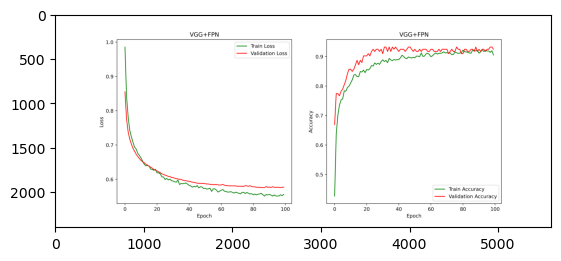

In [54]:
plt.imshow(img);
# plt.axis("off");
plt.show()

In [27]:
img.shape

(2400, 5600, 4)

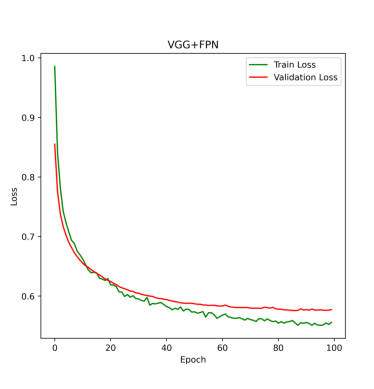

In [53]:
plt.imshow(img[:,500:2800])
plt.axis("off");
plt.savefig('high_dpi_image.png', dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()


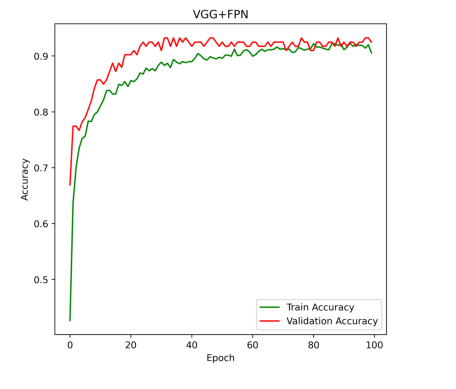

In [73]:
plt.imshow(img[200:2400,2800:5400])
plt.axis("off");
plt.savefig('high_dpi_image1.png', dpi=1000, bbox_inches='tight', pad_inches=0)
plt.show()